<a href="https://colab.research.google.com/github/dani-lbnl/eyecopod/blob/main/tutorial_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on NN
- how to interactively select your training set from image
- how to save crops
- how to load crops
- how to featurize image
- how to train NN

## Import libraries

In [1]:
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future,io
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from functools import partial
import pandas as pd
import numpy as np
import os

In [5]:
from google.colab import files   # file download
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

inputpath = '/content/drive/My Drive/mentees/2023/CamilleCatolos/imgs/'
outputpath = '/content/drive/My Drive/mentees/2023/CamilleCatolos/imgs/'

Mounted at /content/drive


In [4]:
!pip install interactivecrop --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.7 MB/s eta 0:00:00


In [22]:
# Import the cropping widget based on ipywidgets and pillow
from interactivecrop.interactivecrop import main as crop

## Check input folder

In [9]:
%ls "$inputpath"

iPAD2_C28_EX02.JPG


In [11]:
filename = 'iPAD2_C28_EX02.JPG'
from skimage import io
data = io.imread(inputpath+filename)
print(data.shape)

(960, 720, 3)


## Segment foreground and background using thresholding (unsupervised)

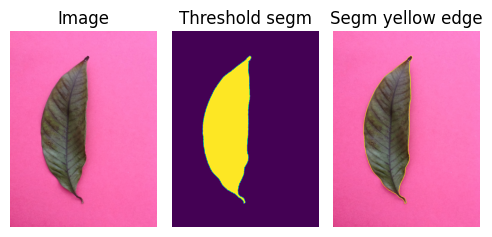

In [30]:
from skimage.filters import threshold_isodata,try_all_threshold,median
onechannel = median(data[:,:,0])
tmip = threshold_isodata(onechannel)
result = onechannel<tmip

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5, 5))
ax[0].imshow(data)
ax[0].set_title('Image')
ax[0].set_axis_off()

ax[1].imshow(result)
ax[1].set_title('Threshold segm')
ax[1].set_axis_off()

ax[2].imshow(segmentation.mark_boundaries(data, result, mode='thick'))
ax[2].set_title('Segm yellow edge')
ax[2].set_axis_off()
fig.tight_layout()

## Interactive widget for crop selection

In [49]:
# Define the callback to save the image crop
def callback(image_name, shape):
    df = pd.DataFrame(columns=['file','cropdim'])
    df.loc[0,:]= image_name, shape.size
    df.to_csv('training.csv', mode='a', header=False)

In [50]:
#Create df to save crops
import pandas as pd
df = pd.DataFrame(columns = ['filename', 'cropDim'])
df.to_csv('training.csv', mode='w', header=True)

In [66]:
PATH_TO_SAMPLES = inputpath
image_list = [PATH_TO_SAMPLES+i for i in os.listdir(PATH_TO_SAMPLES)]
image_name_list = [i[:-4].title() for i in os.listdir(PATH_TO_SAMPLES)]

In [67]:
#RERUN as many times you want to obtain crops
crop(image_list, image_name_list=image_name_list, callback=callback, continuous_update=False)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

In [54]:
%cat training.csv


,filename,cropDim
0,Ipad2_C28_Ex02,"(240, 320, 96, 320)"
0,Ipad2_C28_Ex02,"(409, 320, 71, 320)"


# Compute local features for a single- or multi-channel nd image.
- Intensity, gradient intensity and local structure are computed at different scales using Gaussian blurring.

In [55]:
# Clean selections
df = pd.read_csv('training.csv')

In [56]:
#df.drop(df.index[[1]], inplace=True)
df

,Unnamed: 0,filename,cropDim
0,0,Ipad2_C28_Ex02,"(240, 320, 96, 320)"
1,0,Ipad2_C28_Ex02,"(409, 320, 71, 320)"


In [59]:
#Construct training
training_labels = np.zeros(onechannel.shape, dtype=np.uint8)

for i,tup in enumerate(df['cropDim']):
    w,h,dw,dh = eval(tup)
    training_labels[h:(h+dh),w:(w+dw)]=i+1

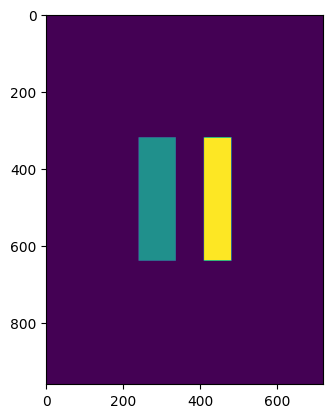

In [60]:
plt.imshow(training_labels)

# Feature Extraction:
- local features based on local characteristics at different scales (sigma)
- characteristics: intensity, edges and textures

In [61]:
import skimage as ski
ski.__version__

'0.19.3'

In [65]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)

features = features_func(data)


## Classification with RF
More at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [68]:
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

# Classification with MLP
- using relu activation function, adam solver for weight optimization,
- alpha = 0.0001, batch_size=200, learning_rate = constant, shuffle samples, validation_fraction=0.1
- More at https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier


In [ ]:
clf = MLPClassifier(random_state=1, activation = 'relu', solver = 'adam', alpha = 0.0001, batch_size=200, max_iter=100)
#clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

/Users/dani/anaconda3/envs/dip3d/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



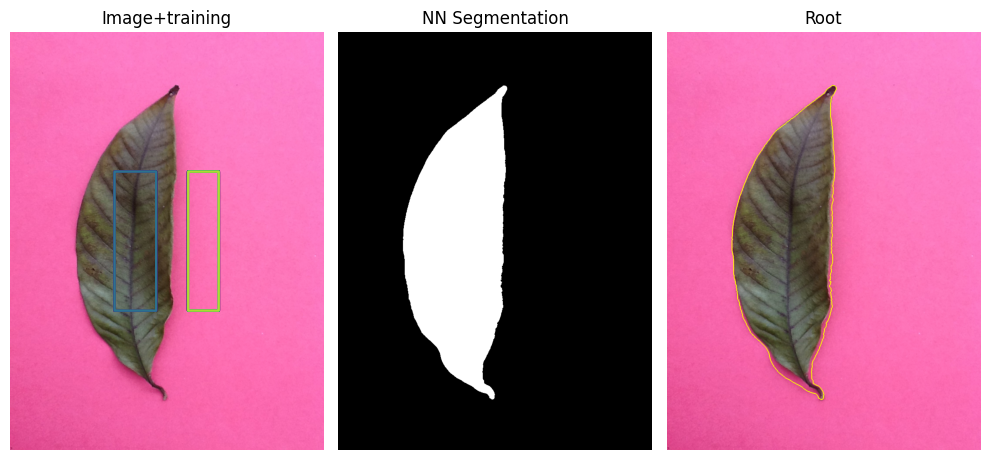

In [70]:
# Visualization of results
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 10))
ax[0].imshow(data)
ax[0].contour(training_labels)
ax[0].set_title('Image+training')
ax[0].set_axis_off()
ax[1].imshow(result == 1,cmap='gray') #label=1 is the first class selected from crop
ax[1].set_title('NN Segmentation')
ax[1].set_axis_off()
ax[2].imshow(segmentation.mark_boundaries(data, result, mode='thick'))
ax[2].set_title('Root')
ax[2].set_axis_off()
fig.tight_layout()

In [76]:
from skimage import measure

In [77]:
#Postprocess segmentation result
def getLargestCC(segments):
    '''Return a mask corresponding to the largest object'''
    labels = measure.label(segments)
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segments.flat))
    return largestCC

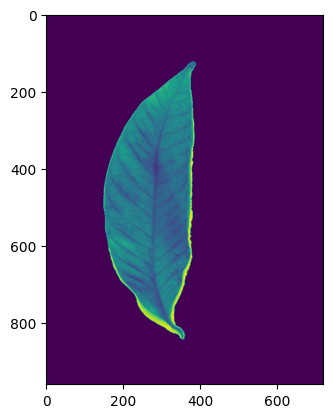

In [80]:
result2 = getLargestCC(result==1)
from scipy import ndimage
result2 = ndimage.binary_fill_holes(result2)
plt.imshow(result2*onechannel)

In [82]:
props = measure.regionprops_table(measure.label(result2), intensity_image=onechannel, properties=('area','major_axis_length','minor_axis_length','max_intensity','mean_intensity','min_intensity'))
props_df = pd.DataFrame(props)
props_df

,area,major_axis_length,minor_axis_length,max_intensity,mean_intensity,min_intensity
0,114408,652.020096,235.881822,227.0,98.115359,32.0


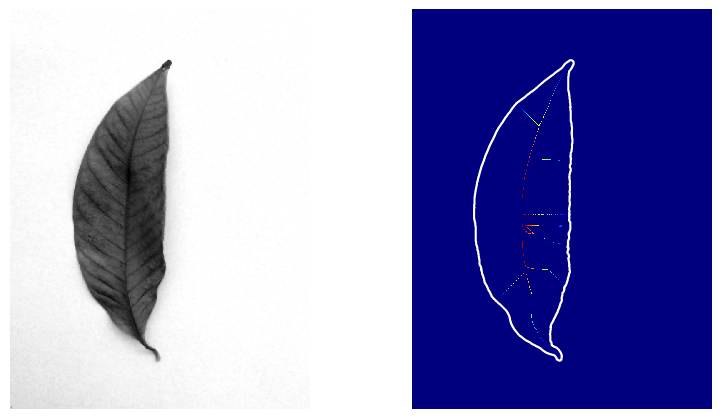

In [84]:
from skimage.morphology import medial_axis
skel, distance = medial_axis(result2, return_distance=True)
dist_on_skel = distance * skel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(onechannel, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap='jet', interpolation='nearest')
ax2.contour(result2, [0.5], colors='w')
ax2.axis('off')

fig.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()

In [86]:
#Double check if parametrized properly after pandas
print(data.shape)
for i,tup in enumerate(df['cropDim']):
    print(eval(tup))
    w,h,dw,dh = eval(tup)
plt.imshow(full_img[h:(h+dh),w:(w+dw)])

(960, 720, 3)
(240, 320, 96, 320)
(409, 320, 71, 320)


NameError: ignored